In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import csv

font = {'family':'sans-serif', 'size'   : 18}
rc('font', **font)

design_type = "validation"  # emulator or validation

if design_type == "emulator":
    design = np.loadtxt("SCT_EmulatorInputsDesign.csv", delimiter=',', skiprows=1)
elif design_type == "validation":
    design = np.loadtxt("SCT_ValidationInputsDesign.csv", delimiter=',', skiprows=1)
elif design_type == "oats":
    design = np.asarray([[7, 900, 11.157, -6.3422,150,-1.79], 
                         [11, 900, 11.157, -6.3422,150,-1.79], 
                         [10.4613, 500, 11.157, -6.3422,150,-1.79], 
                         [10.4613, 1300, 11.157, -6.3422,150,-1.79], 
                         [10.4613, 900, 2, -6.3422,150,-1.79], 
                         [10.4613, 900, 21, -6.3422,150,-1.79], 
                         [10.4613, 900, 11.157, -7,150,-1.79], 
                         [10.4613, 900, 11.157, -1,150,-1.79], 
                         [10.4613, 900, 11.157,  -6.3422,10,-1.79], 
                         [10.4613, 900, 11.157,  -6.3422,500,-1.79], 
                         [10.4613, 900, 11.157,  -6.3422,150,-2.3], 
                         [10.4613, 900, 11.157,  -6.3422,150,-1.3]])
else:
    print('Please specify design_type')

### Columns: qv_bl, inv, delt, delq, na, b_aut

In [19]:
### Random perturbations profile
def rand_heights_pert(b_rand_heights, design, row):
    rand_heights = np.asarray(b_rand_heights)
    inversion_height = design[row, 1]
    rand_heights[1] = inversion_height
    rand_heights[2] = inversion_height + 1
    return rand_heights

def heights_profile_pert(full_heights_profile, design, row):
    heights_profile = np.asarray(full_heights_profile)
    inversion = design[row, 1]
    
    ind = np.nonzero(np.where(full_heights_profile - inversion > 0, 1, 0))[0][0]
    heights_profile[ind - 1] = inversion
    heights_profile = np.delete(heights_profile, slice(1, ind-1))
    heights_profile[2] = inversion + 30
    return heights_profile

def theta_profile_pert(b_theta_profile, design, row, heights_profile, th_gradient):
    '''
    Note that the delt is the perturbation but because it's applied over 30m, the difference is a bit bigger
    '''
    delt = design[row, 2]
    inversion = design[row,1]
    
    intercept = (-1)*th_gradient*(b_theta_profile[0] + delt) + inversion
    theta_profile = [(y - intercept)/th_gradient for y in heights_profile]
    theta_profile[:2] = b_theta_profile[:2]
    return np.asarray(theta_profile)

def q_fields_profiles_pert(b_q_fields_profiles, design, row, heights_profile, qv_gradient, length_of_base):
    qv_bl = design[row, 0]*1e-3
    delq = design[row, 3]*1e-3
    na = design[row, 4]
    inversion = design[row,1]
    
    intercept = (-1)*qv_gradient*(qv_bl + delq) + inversion
    qv_profiles = [(y - intercept)/qv_gradient for y in heights_profile]
    qv_profiles[:2] = np.asarray([qv_bl]*2)
    
    accum_bl_num = na*1e6
    accum_bl_mass = find_mass(accum_bl_num)
    
    b_accum_mass = b_q_fields_profiles[3*length_of_base:4*length_of_base]
    b_accum_num = b_q_fields_profiles[4*length_of_base:5*length_of_base]
    
    accum_mass_profile = np.ones(len(heights_profile))*b_accum_mass[-1]
    accum_mass_profile[:2] = np.asarray([accum_bl_mass]*2)
    
    accum_num_profile = np.ones(len(heights_profile))*b_accum_num[-1]
    accum_num_profile[:2] = np.asarray([accum_bl_num]*2)
    
    aitken_mass_profile = b_q_fields_profiles[length_of_base:2*length_of_base]
    aitken_num_profile = b_q_fields_profiles[2*length_of_base:3*length_of_base]
    len_diff = len(aitken_mass_profile)-len(heights_profile)
    if len_diff > 0:
        aitken_mass_profile = np.delete(aitken_mass_profile, slice(((-1)*len_diff)-1,-1))
        aitken_num_profile = np.delete(aitken_num_profile, slice(((-1)*len_diff)-1,-1))
    elif len_diff < 0:
        aitken_mass_profile = np.insert(aitken_mass_profile, 2, np.asarray([aitken_mass_profile[-1]]*abs(len_diff)))
        aitken_num_profile = np.insert(aitken_num_profile, 2, np.asarray([aitken_num_profile[-1]]*abs(len_diff)))
    
    q_fields_profiles = np.hstack((qv_profiles, aitken_mass_profile, aitken_num_profile, accum_mass_profile, accum_num_profile))
    
    return q_fields_profiles, qv_profiles, accum_mass_profile, accum_num_profile

def find_mass(N_mode):
    V = (4*np.pi/3)*(N_mode)*0.5*(0.2e-6)**3*np.exp(9*(np.log(1.5)**2)/2)   #  N_mode should be in # m^-3
    m = V*1500
    return m


def b_aut_pert(design, row, bin_dict):
    b_aut = design[row, 5]
    for key, val in bin_dict.items():
        if val[0] <= b_aut <= val[1]:
            b_col = val[2]
            #b_label = "{:2.2}<=b_aut<{:2.2}".format(val[0],val[1])
    return b_aut, b_col#, b_label

In [15]:
find_mass(150e6)

7.899980057973193e-09

In [13]:
7.8e-9/1.97e-9

3.9593908629441628

In [20]:
### Base profiles
b_rand_heights = [0.0, 900.0, 901.0, 3050.01]
full_heights_profile = [10.0, 142.7, 185.7, 228.7, 271.7, 314.7, 357.7, 401.8, 445.9, 490.0, 534.2, 578.3, 623.6, 668.9, 714.2, 759.4, 804.7, 851.7, 898.6, 945.5, 992.5, 1039.4, 1087.6, 1135.9, 1184.1,
                   1232.3, 1280.5, 1330.2, 1380.0, 1429.7, 1479.4, 1529.1, 1580.2, 1631.3, 1682.3, 1733.4, 1784.5, 1837.1, 1889.7, 1942.3, 1994.9, 2047.5, 2101.4, 2155.4, 2209.3, 2263.2, 2317.2, 
                   2372.5, 2427.8, 2483.1, 2538.4, 2593.7, 2651.5, 2709.2, 2766.9, 2824.7, 2882.4, 2940.1, 2997.9, 3055.6, 3100.0]
b_heights_profile = np.delete(full_heights_profile, slice(1,18))
b_theta_profile = [290.969, 290.969, 302.126, 302.394, 302.661, 302.936, 303.211, 303.486, 303.761, 304.036, 304.319, 304.603, 304.886, 305.169, 305.453, 305.744, 306.035, 306.326, 306.617, 306.909, 
                 307.208, 307.508, 307.808, 308.108, 308.408, 308.715, 309.022, 309.33, 309.637, 309.945, 310.26, 310.575, 310.89, 311.206, 311.521, 311.85, 312.179, 312.508, 312.837, 313.167, 
                 313.496, 313.825, 314.154, 314.483]
b_q_fields_profiles = [0.0104613, 0.0104613, 0.0041191, 0.00410173, 0.00408435, 0.00406649, 0.00404863, 0.00403078, 0.00401292, 0.00399506, 0.00397665, 0.00395824, 0.00393983, 0.00392142, 0.00390302, 
                     0.0038841, 0.00386519, 0.00384628, 0.00382736, 0.00380845, 0.00378897, 0.00376949, 0.00375002, 0.00373054, 0.00371106, 0.00369109, 0.00367112, 0.00365116, 0.00363119, 
                     0.00361122, 0.00359074, 0.00357026, 0.00354978, 0.0035293, 0.00350881, 0.00348744, 0.00346606, 0.00344468, 0.0034233, 0.00340192, 0.00338054, 0.00335916, 0.00333778, 
                     0.00331641, 1.8424807262418176e-11, 1.8424807262418176e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 
                     2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 
                     2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 
                     2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 
                     2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 
                     2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 
                     2.4566409683224232e-11, 2.4566409683224232e-11, 2.4566409683224232e-11, 150000000.0, 150000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 
                     200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 
                     200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 
                     200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 200000000.0, 1.9749950144932982e-09, 
                     1.9749950144932982e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 
                     1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 
                     1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 
                     1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 
                     1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 
                     1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 1.3166633429955323e-09, 
                     1.3166633429955323e-09, 150000000.0, 150000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 
                     100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 
                     100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 
                     100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0]
b_b_parameter = -1.79

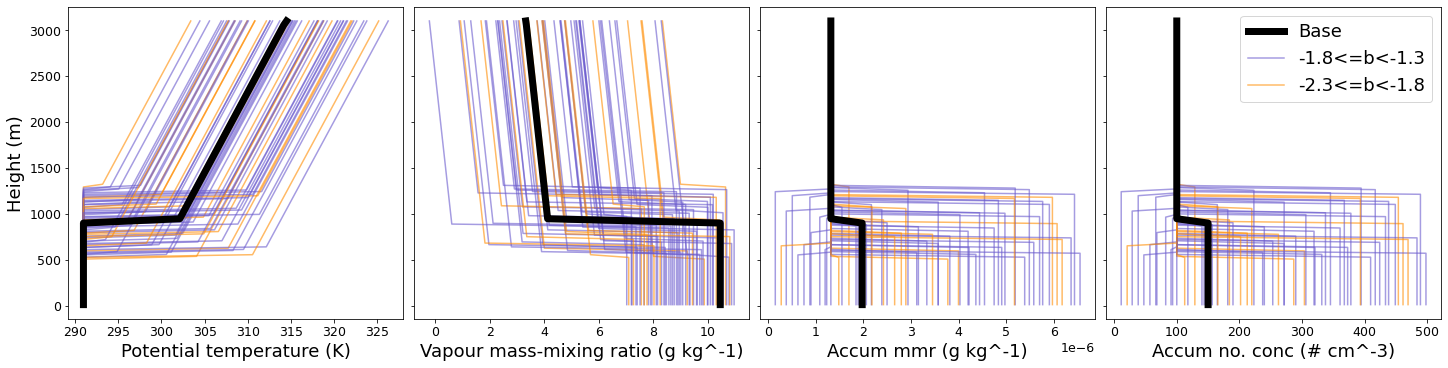

In [34]:
len_of_heights=np.empty(len(design))
th_gradient = (b_heights_profile[-1] - b_heights_profile[2])/(b_theta_profile[-1] - b_theta_profile[2])
qv_gradient = (b_heights_profile[-1] - b_heights_profile[2])/(b_q_fields_profiles[len(b_heights_profile)-1] - b_q_fields_profiles[2])

#cols = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10","C11", "C12"]
cols = ['blue','darkorange','slateblue']
base_col = 'black' #'deepskyblue'
a=0.6
b_range = np.linspace(-2.3, -1.3, 3)
bin_dict={}
for i in range(1,len(b_range)):
    key="bin_{}".format(str(i))
    bin_dict[key] = [b_range[i-1], b_range[i], cols[i]]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5), sharey=True,constrained_layout=True)

lines=[]
for i in range(len(design)):
    if design_type!="oats":
        b_aut, b_col = b_aut_pert(design, i, bin_dict)
    else:
        b_col = cols[i]
    
    heights_profile = heights_profile_pert(full_heights_profile, design, i)
    len_of_heights[i] = len(heights_profile)
    diff = np.delete(np.asarray(heights_profile), 0) - np.delete(np.asarray(heights_profile), -1)
    bool_arr = np.where(diff<0, False, True)
    if np.all(diff) == False:
        print("error")
    theta_profile = theta_profile_pert(b_theta_profile, design, i, heights_profile, th_gradient)
    ax[0].plot(theta_profile, heights_profile,c=b_col,alpha=a)
    length_of_base = len(b_heights_profile)
    q_fields_profiles, qv_profiles, accum_mass_profile, accum_num_profile = q_fields_profiles_pert(b_q_fields_profiles, design, i, heights_profile, qv_gradient, length_of_base)
    ax[1].plot(np.multiply(qv_profiles, 1000), heights_profile,c=b_col,alpha=a)
    ax[2].plot(np.multiply(accum_mass_profile, 1000), heights_profile,c=b_col,alpha=a)
    line, = ax[3].plot(np.multiply(accum_num_profile, 1e-6), heights_profile,c=b_col,alpha=a) #,label=b_label)
    lines.append(line)

ax[0].set_ylabel("Height (m)")

ax[0].plot(b_theta_profile, b_heights_profile, base_col, linewidth=7)
ax[0].set_xlabel("Potential temperature (K)")
ax[1].plot(np.multiply(b_q_fields_profiles[:length_of_base],1000), b_heights_profile, base_col, linewidth=7)
ax[1].set_xlabel("Vapour mass-mixing ratio (g kg^-1)")
ax[2].plot(np.multiply(b_q_fields_profiles[3*length_of_base:4*length_of_base],1000), b_heights_profile, base_col, linewidth=7)
ax[2].set_xlabel("Accum mmr (g kg^-1)")
b_line, = ax[3].plot(np.multiply(b_q_fields_profiles[4*length_of_base:5*length_of_base],1e-6), b_heights_profile, base_col, linewidth=7, label="Base")
ax[3].set_xlabel("Accum no. conc (# cm^-3)")
if design_type!="oats":
    ax[3].legend([b_line, lines[1], lines[4]], ["Base", "{:2.2}<=b<{:2.2}".format(bin_dict['bin_2'][0],bin_dict['bin_2'][1]), "{:2.2}<=b<{:2.2}".format(bin_dict['bin_1'][0],bin_dict['bin_1'][1])],loc=1) #, , lines[0], lines[1]"{:2.2}<=b<{:2.2}".format(bin_dict['bin_3'][0],bin_dict['bin_3'][1]), "{:2.2}<=b<{:2.2}".format(bin_dict['bin_4'][0],bin_dict['bin_4'][1])], loc=1)
    #ax[3].legend([b_line], ["Base"],loc=1) #, , lines[0], lines[1]"{:2.2}<=b<{:2.2}".format(bin_dict['bin_3'][0],bin_dict['bin_3'][1]), "{:2.2}<=b<{:2.2}".format(bin_dict['bin_4'][0],bin_dict['bin_4'][1])], loc=1)
else:
    handles=[]
    ax[3].legend(lines, ['oat1', 'oat2','oat3','oat4','oat5', 'oat6', 'oat7','oat8','oat9','oat10','oat11','oat12'], loc=1)
#plt.legend()
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.show()

#fig.savefig("perturbed_profiles_ppe.png")

In [21]:
len_of_heights=np.empty(len(design))
length_of_base = len(b_heights_profile)
th_gradient = (b_heights_profile[-1] - b_heights_profile[2])/(b_theta_profile[-1] - b_theta_profile[2])
qv_gradient = (b_heights_profile[-1] - b_heights_profile[2])/(b_q_fields_profiles[len(b_heights_profile)-1] - b_q_fields_profiles[2])

full_list=[]
for i in range(len(design)):
    rand_heights = rand_heights_pert(b_rand_heights, design, i)
    heights_profile = heights_profile_pert(full_heights_profile, design, i)
    theta_profile = theta_profile_pert(b_theta_profile, design, i, heights_profile, th_gradient)
    q_fields_profiles, qv_profiles, accum_mass_profile, accum_num_profile = q_fields_profiles_pert(b_q_fields_profiles, design, i, heights_profile, qv_gradient, length_of_base)
    b_aut = design[i,5]
    
    rand_heights_list = [str(element) for element in rand_heights]
    heights_profile_list = [str(element) for element in heights_profile]
    theta_profile_list = [str(element) for element in theta_profile]
    q_fields_profiles_list = [str(element) for element in q_fields_profiles]
    
    rand_heights_list=",".join(rand_heights_list)
    heights_profile_list=",".join(heights_profile_list)
    theta_profile_list=",".join(theta_profile_list)
    q_fields_profiles_list=",".join(q_fields_profiles_list)
    
    list_design = [rand_heights_list, heights_profile_list, theta_profile_list, q_fields_profiles_list, b_aut]
    full_list.append(list_design)


with open('string_master_array_val.csv','w', newline='') as result_file:
    wr = csv.writer(result_file, delimiter="|")
    for l in full_list:
        wr.writerow(l)

#### Queue/comp time efficiency

107159.8
53092.8
28633.6
16506.4


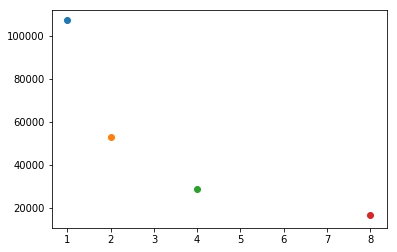

In [4]:

nodes = [1,2,4,8]
time_3_101_steps = [[104775,103446,96352, 119931, 111295],
                   [56861, 53541, 50412, 53953, 50697],
                   [32740, 28210, 26542, 28635, 27041],
                   [20952, 15665, 14940, 15913, 15062]]
fig,ax = plt.subplots()
for i,trial in enumerate(time_3_101_steps):
    t_mean = np.mean(trial)
    print(t_mean)
    ax.scatter(nodes[i], t_mean)

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

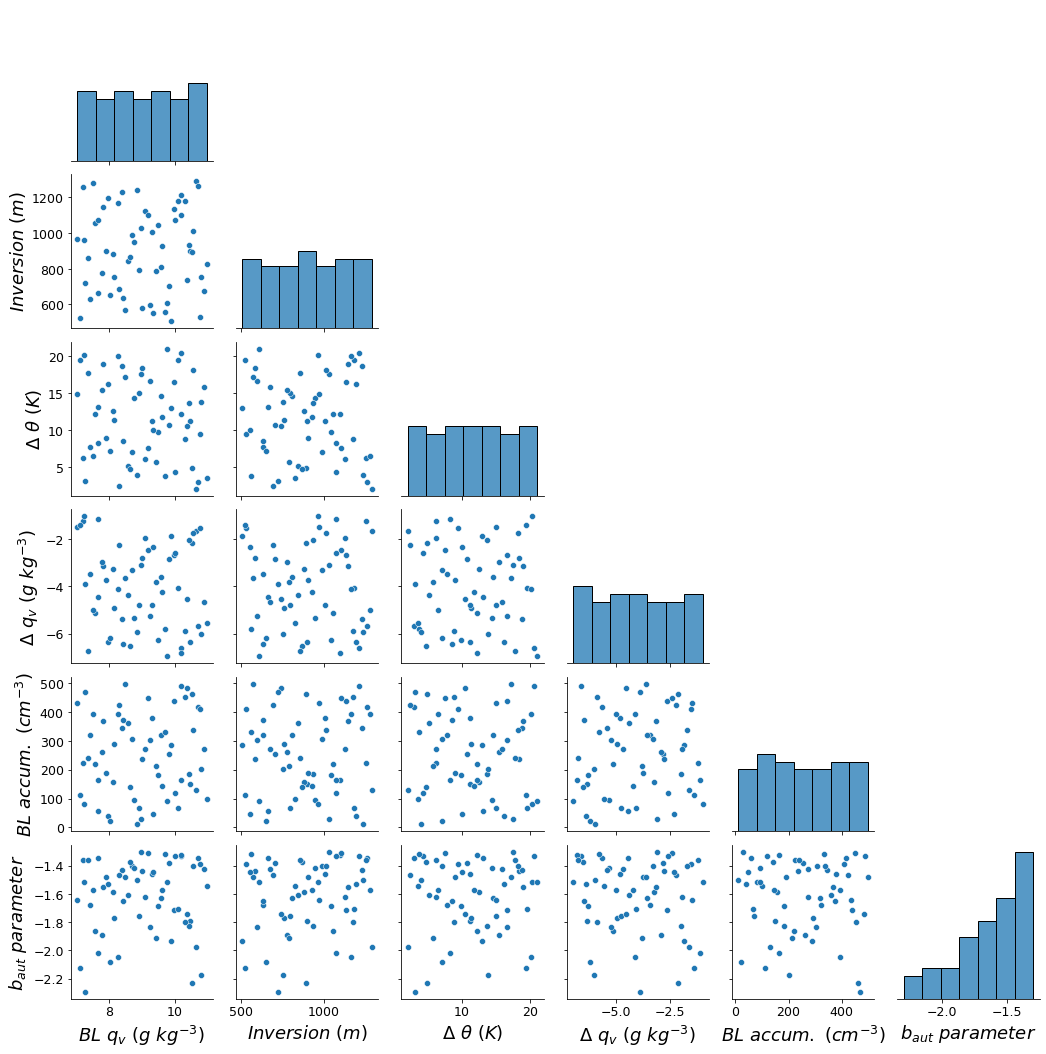

In [64]:
em_design = np.loadtxt("SCT_EmulatorInputsDesign.csv", delimiter=',', skiprows=1)
val_design = np.loadtxt("SCT_ValidationInputsDesign.csv", delimiter=',', skiprows=1)
names=['$BL~q_{v}~(g~kg^{-3})$', '$Inversion~(m)$', r'$\Delta~\theta~(K)$', '$\Delta~q_{v}~(g~kg^{-3})$', '$BL~accum.~(cm^{-3})$', '$b_{aut}~parameter$']

em_dict={}
val_dict={}
for i in range(len(names)):
    em_dict[f'em_{names[i]}'] = em_design[:,i]
    val_dict[f'val_{names[i]}'] = val_design[:,i]

em_design = pd.DataFrame(data=em_design, columns=names)
#val_design = pd.DataFrame(data=val_design, columns=names, index=['val']*len(val_design))
#vertical_stack = pd.concat([em_design, val_design], axis=0)
seaborn.pairplot(em_design, corner=True)
#plt.savefig("/home/users/eers/sct/lh_design/pairwise.png")

{'val_qv_bl': array([ 7.14449103,  8.05310899,  8.22905396,  7.33263138,  7.57954593,
       10.5992205 ,  9.52897713,  7.44493456,  8.87440646,  7.73834698,
        9.66191674,  8.53989057,  9.40609148,  9.13284314,  9.17030469,
       10.72968849,  8.37668136, 10.9432333 ,  7.06637512,  9.72658968,
       10.45909237, 10.27200362, 10.0913405 ,  7.95405281]), 'val_inv': array([ 534.49075562,  717.98508677,  595.28042782,  740.05788533,
        544.59417559, 1169.39002365,  616.11331893, 1218.0419937 ,
       1034.9523239 ,  839.94725875,  916.23083552,  818.30823262,
        945.76653013,  800.83314358, 1000.0077855 ,  985.48358693,
        782.82889526, 1019.52995389, 1251.9846865 , 1285.87256593,
        513.5966585 ,  661.53816892, 1189.4147363 ,  761.44269076]), 'val_delt': array([ 2.88494596,  4.94429434,  4.66887882,  8.0928247 , 16.45090021,
        3.31702386, 17.88558864,  5.90278546, 17.33939579,  2.52712965,
       19.03473807, 14.18825224,  4.26054556, 14.8424987 , 11.0031